## TO-DO
- Implement object detection
- Evaluation (metrics)

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
import matplotlib.pyplot as plt

from utils.loader import DataLoader
from models.effnet_encoder import EffnetEncoder
from models.mtl_framework import MTLFramework
from utils import tools, config

In [2]:
# Set configs
batch_size = 16
batch_size_val = 16
num_train, num_val, num_test = config.config['num_train'], config.config['num_val'], config.config['num_test']
img_height, img_width, channels = config.config['input_shape']

In [3]:
# Load our data pipeline
loader = DataLoader(batch_size=batch_size, batch_size_val=batch_size_val)

# Train set
img_ds = loader.get_image_ds().repeat()
masks_ds = loader.get_mask_ds().repeat()
label_ds = loader.get_binary_ds().repeat()
bbox_ds = loader.get_bboxes_ds().repeat()

# Validation set
img_ds_val = loader.get_image_ds(val=True).repeat()
masks_ds_val = loader.get_mask_ds(val=True).repeat()
label_ds_val = loader.get_binary_ds(val=True).repeat()
bbox_ds_val = loader.get_bboxes_ds(val=True).repeat()

Plot some examples (Ignore if training)

In [5]:
# Make some examples
examples = tf.data.Dataset.zip((img_ds, masks_ds, bbox_ds)).as_numpy_iterator()
display_list = next(examples)

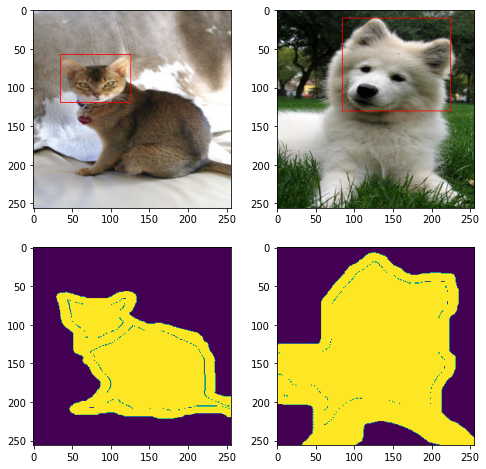

In [11]:
# View some examples
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8,8))
for i in range(2):
    box_img = tf.image.draw_bounding_boxes(tf.expand_dims(display_list[0][i,...], 0), tools.fix_bbox(display_list[2][i]).reshape([1,1,4])/256, np.array([[255, 0, 0]]))
    ax1[i].imshow(tf.keras.utils.array_to_img(tf.squeeze(box_img)))
    ax2[i].imshow((display_list[1][i,...]))

Build our MTL

In [4]:
# Get encoder
base_model_name = 'B0'
encoder = EffnetEncoder(base_model_name, (img_height, img_width, channels)).build_encoder(trainable=False)


In [ ]:
encoder.summary()

In [5]:
# Use our MTL framework to custom build a model
mtl_builder = MTLFramework(encoder, (img_height, img_width, channels))
mtl_builder.add_segmentation_head()
mtl_builder.add_binary_classification_head(base_model_name, trainable=False)
model = mtl_builder.build_mtl_model()

In [ ]:
model.summary()

Train model

In [13]:
def generator_img():
    ''' Merges together datasets into a unified generator to pass for training '''
    a = img_ds.as_numpy_iterator()
    b = masks_ds.as_numpy_iterator()
    c = label_ds.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        
        # Regularisation and shuffling
        X, Y1, Y2 = tools.get_randomised_data([X, Y1, Y2])
        X, Y1 = tools.data_augmentation(X, Y1)
        
        yield X, (Y1, Y2)

In [14]:
def generator_img_val():
    ''' Merges together datasets into a unified generator to pass for training '''
    a = img_ds_val.as_numpy_iterator()
    b = masks_ds_val.as_numpy_iterator()
    c = label_ds_val.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        
        yield X, (Y1, Y2)

In [15]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss={'segnet_out' : tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    'bin_class_out' : tf.keras.losses.BinaryCrossentropy()},
              metrics=['accuracy'])

In [ ]:
model.fit(generator_img(), validation_data=generator_img_val(), epochs=5, steps_per_epoch=num_train//batch_size, validation_steps=num_val//batch_size_val)

In [ ]:
model.save('EffishingNet')

## Test on test-set

In [4]:
model = tf.keras.models.load_model('EffishingNet')

In [5]:
img_ds_test = loader.get_image_ds(test_mode=True)
masks_ds_test = loader.get_mask_ds(test_mode=True)
label_ds_test = loader.get_binary_ds(test_mode=True)
#bbox_ds_test = loader.get_bboxes_ds(test=True)

In [11]:
# Predict on test-set
seg_pred, bin_pred = model.predict(img_ds_test, batch_size=10)
seg_pred = tf.where(seg_pred >= 0, 1, 0) # Convert to {0,1} binary classes
bin_pred = np.round(bin_pred) # Round confidence score

bin_acc = np.sum(bin_pred == label_ds_test)/label_ds_test.shape[0]
seg_acc = np.sum(seg_pred == masks_ds_test)/(masks_ds_test.shape[0]*(img_height*img_width))
print(f'Binary Acc: {round(bin_acc*100, 3)}%,   Seg Acc: {round(seg_acc*100, 3)}%')

Binary Acc: 99.322%,   Seg Acc: 95.25%


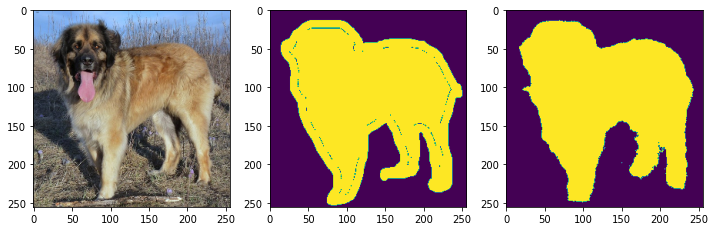

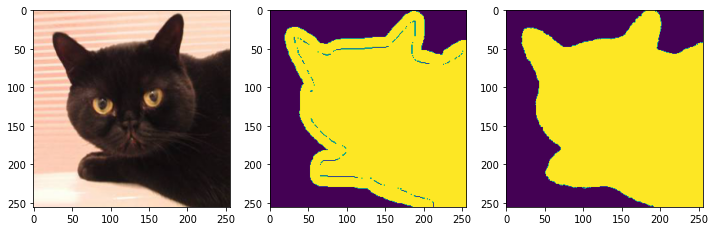

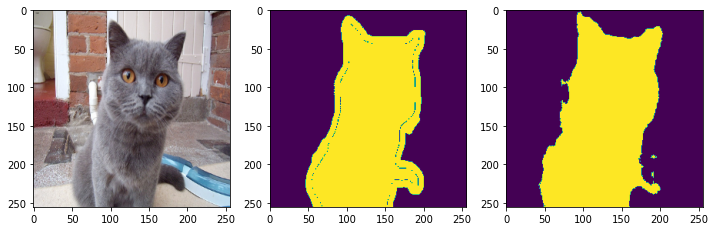

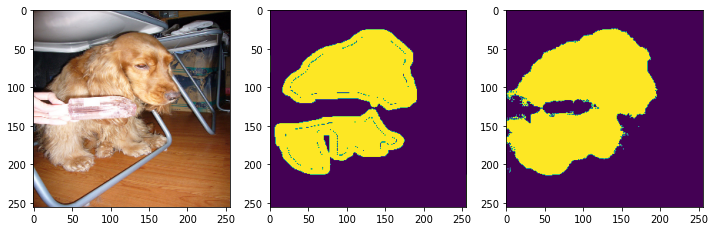

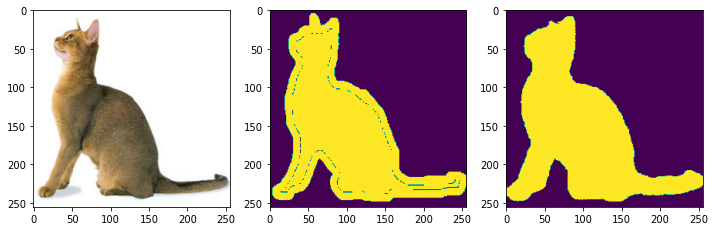

In [22]:
idx = list(range(img_ds_test.shape[0]))
random.shuffle(idx)
for i in range(5):
    tools.show_seg_pred(img_ds_test[idx[i]], masks_ds_test[idx[i]], seg_pred[idx[i]][tf.newaxis, ...])